In [50]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt

device = torch.device('cpu')  # Usamos CPU para este ejemplo

In [51]:
# Define the analytical function
def analytical(x):
    return -2 * torch.log(1 + x**2)

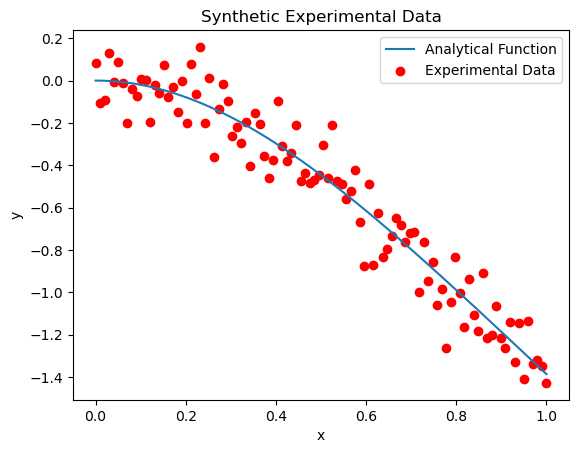

In [95]:
import torch


# Define the analytical function
def analytical(x):
    y_values = -2 * torch.log(1 + x**2)
    return y_values

# Define the analytical function
def experimental(x):
    y_values = -2 * torch.log(1 + x**2)
    noise = torch.randn(y_values.shape) * 0.1  # Ajusta la magnitud del ruido según sea necesario
    y_noisy = y_values + noise  
    return y_noisy



# Step 1: Generate x values
x_values = torch.linspace(0, 1, steps=100)  # 100 puntos entre 0 y 1

# Step 2: Calculate y values using the analytical function
y_values = analytical(x_values)

# Plot the original analytical function
plt.plot(x_values.numpy(), analytical(x_values).numpy(), label='Analytical Function')

# Plot the synthetic experimental data with noise
plt.scatter(x_values.numpy(), experimental(x_values).numpy(), color='red', label='Experimental Data')

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Experimental Data')
plt.legend()

# Show the plot
plt.show()
 

In [96]:
def Legendre(x: torch.Tensor, n: int) -> torch.Tensor:

    # Inicializa los dos primeros polinomios de Legendre
    legendre_polynomials = [torch.ones_like(x), x]

    # Calcula los polinomios de Legendre hasta el grado n
    for _ in range(2, n):
        # Coeficientes para la relación de recurrencia de los polinomios de Legendre
        a = (2 * _ - 1) / _
        b = (_ - 1) / _

        # Calcula el polinomio de Legendre de grado i usando la relación de recurrencia
        legendre_polynomial = a * x * legendre_polynomials[-1] - b * legendre_polynomials[-2]

        # Añade el polinomio de Legendre de grado i a la lista
        legendre_polynomials.append(legendre_polynomial)

    # Devuelve los polinomios de Legendre como un tensor de PyTorch
    return torch.stack(legendre_polynomials, dim=1)

class OrthogonalNeuralNetwork(nn.Module):
    
    def __init__(self, n: int, lb: float, ub: float):
        super(OrthogonalNeuralNetwork, self).__init__()
        self.n = n
        self.lb = lb
        self.ub = ub
        
        # Inicializa los coeficientes como parámetros del modelo que se aprenderán durante el entrenamiento
        self.weights = torch.nn.Parameter(torch.zeros(n, dtype=torch.float64))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normaliza la entrada
        x = 2 * (x - self.lb) / (self.ub - self.lb) - 1

        # Calcula los polinomios de Legendre hasta el grado especificado
        legendre_polynomials = Legendre(x, self.n)

        # Realiza una combinación lineal de los polinomios de Legendre seleccionados utilizando los coeficientes aprendidos
        return torch.matmul(legendre_polynomials, self.weights) 
    

# Function to compute derivatives
def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy    

In [97]:
lb = 1e-12
ub = 1
x = torch.linspace(lb, ub, 100, dtype=torch.float64, requires_grad=True).to(device)

# Set requires_grad=True separately
x.requires_grad_(True)

model = OrthogonalNeuralNetwork(5, lb, ub).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'El modelo tiene {num_params} parámetros.')

lambda_1 = torch.nn.Parameter(torch.zeros(1, requires_grad=True, device=device))


# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(list(model.parameters())+ [lambda_1],
                                lr=1,
                                max_iter=100,
                                max_eval=50_000,
                                tolerance_grad=1e-9,
                                history_size=50,
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn=None)
 

# Definir la función de cierre
iter_count=0
def closure():
    global iter_count
    iter_count+=1
    optimizer.zero_grad()
    y_pred = model(x) 
    y_t = x**2*y_pred
    y_x = derivative(y_t, x, order=1)  
    y_xx = derivative(y_t, x, order=2)
    #loss_data = torch.mean(y_t - analytical(x)** 2)
    residuo =  y_xx +  2*y_x/x + lambda_1*(2*torch.exp(y_t)+torch.exp(y_t/2))
    loss_data = torch.mean((y_t - experimental(x))** 2)
    loss_f = criterion(residuo,torch.zeros_like(residuo))
    #loss_f = torch.mean((residuo - torch.zeros_like(residuo))** 2)
    #loss_2 = torch.mean((f(X1, X2) - approximation) ** 2)
    loss = loss_f + loss_data
    
    if iter_count % 100 == 0: 
        print(f'iter {iter_count}, loss: {loss.detach().numpy()}')
    loss.backward(retain_graph=True)
    return loss

# Función para entrenar el modelo
def train_model():
    start_time = time.time()
    #for epoch in range(epochs):
    optimizer.step(closure)
    end_time = time.time()
    y_pred = model(x) 
    y_t = x**2*y_pred
    y_x = derivative(y_t, x, order=1)  
    y_xx = derivative(y_t, x, order=2)
    residuo =  y_xx +  2*y_x/x + 4*(2*torch.exp(y_t)+torch.exp(y_t/2))
    loss = criterion(residuo,torch.zeros_like(residuo))    
    print(f'Final loss: {loss.detach().numpy()}')
    print(f'Tiempo de entrenamiento: {end_time - start_time} segundos')

# Entrenar el modelo
train_model()

El modelo tiene 5 parámetros.
iter 100, loss: 0.009939118018524368
Final loss: 0.00023377139969585846
Tiempo de entrenamiento: 0.13930225372314453 segundos


In [107]:
lambda_1

Parameter containing:
tensor([3.9935], requires_grad=True)

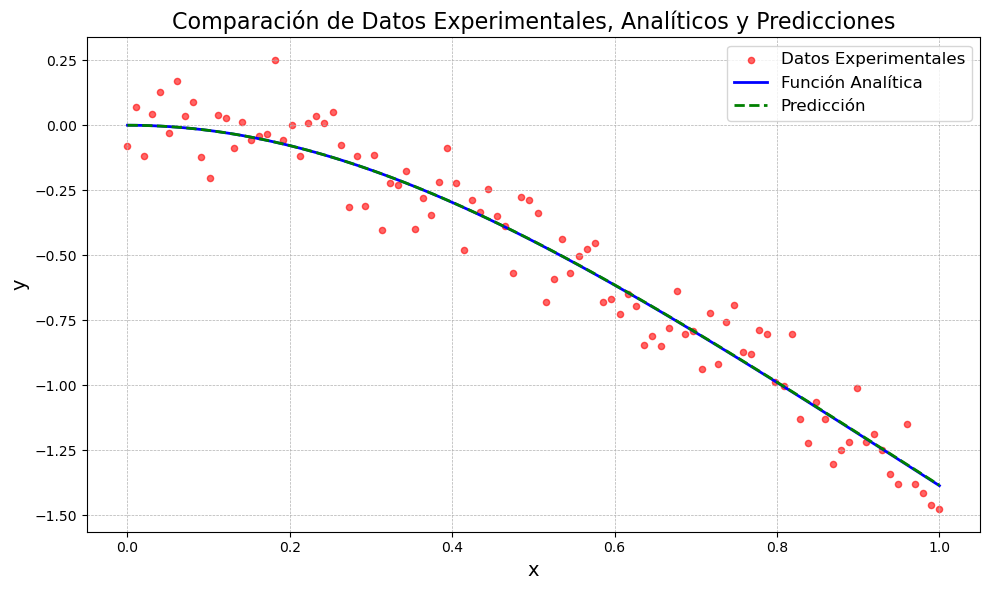

In [106]:
# Step 3: Sort the scaled values to ensure they are ordered
x = torch.linspace(lb, ub, 100, dtype=torch.float64, requires_grad=True).to(device)

# Convert to the desired dtype and move to device
 
# Set requires_grad=True separately
x.requires_grad_(True)

with torch.no_grad():
    y_pred = model(x)
y_pred = x**2*y_pred  
# Convertir tensores a numpy para visualización
x = x.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()

plt.figure(figsize=(10, 6))  # Aumentar el tamaño de la figura
plt.scatter(x_values.numpy(), experimental(x_values).numpy(), color='red', s=20, alpha=0.6, label='Datos Experimentales')  # Ajustar tamaño y transparencia
plt.plot(x_values.numpy(), analytical(x_values).numpy(), color='blue', linewidth=2, label='Función Analítica')  # Ajustar el grosor de la línea
plt.plot(x, y_pred, '--', color='green', linewidth=2, label='Predicción')  # Ajustar el grosor de la línea y añadir etiqueta
plt.xlabel('x', fontsize=14)  # Aumentar el tamaño de fuente de la etiqueta x
plt.ylabel('y', fontsize=14)  # Aumentar el tamaño de fuente de la etiqueta y
plt.title('Comparación de Datos Experimentales, Analíticos y Predicciones', fontsize=16)  # Añadir un título y ajustar el tamaño de fuente
plt.legend(fontsize=12)  # Añadir leyenda y ajustar el tamaño de fuente
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Habilitar la cuadrícula con estilo personalizado
plt.tight_layout()  # Ajustar automáticamente los parámetros de la subtrama
plt.show()